In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])
isp_data_root = "/home/emmanuel/code/isp_data"
# append to path
sys.path.append(str(root))
sys.path.append(str(isp_data_root))

from isp_data.information import download_toy_data


# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns

sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Download Data

In [2]:
download_toy_data()

Folder '/home/emmanuel/code/pysim/datasets/info' Is Already There.


## Mutual Information

In [4]:
from pysim.data.information.gaussian import generate_gaussian_mi_data

In [8]:
n_samples = 10_000
n_features = 10
seed = 1

# create seed (trial number)
res_dict = generate_gaussian_mi_data(
    n_samples=n_samples, n_features=n_features, seed=seed,
)

In [9]:
res_dict.MI

2.6154390674250223

## Estimators

### MINE

In [10]:
from pysim.information.mine import MINE
import torch
import numpy as np
from IPython import display

In [11]:
batch_size = 64
lr = 5e-5
ma_rate = 0.1
trials = 1
# data params
n_samples = 2_000
n_features = 5

mine_list = []
for i_trial in range(trials):
    # generate data

    res_dict = generate_gaussian_mi_data(
        n_samples=n_samples, n_features=n_features, seed=i_trial,
    )

    # create torch tensors
    # create models
    X = torch.Tensor(res_dict.X)
    Y = torch.Tensor(res_dict.Y)

    mine_list.append(MINE(X, Y, batch_size=batch_size, lr=lr, ma_rate=ma_rate))

# initialize differences
dXY_list = np.zeros((trials, 0))

CPU times: user 14min 10s, sys: 30min 59s, total: 45min 9s
Wall time: 1min 41s


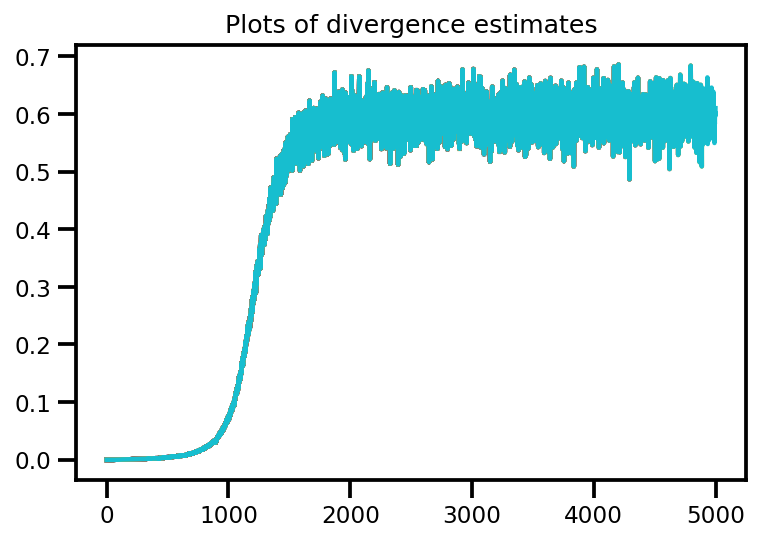

In [12]:
%%time

continue_train = True  # set to True to continue to train
num_big_steps = 50  # number of small steps
num_small_steps = 100  # number of big steps


with tqdm.trange(num_big_steps) as pbar:
    for k in pbar:

        for j in range(num_small_steps):
            pbar.set_description(f"# Small Steps: {j}")
            dXY_list = np.append(dXY_list, np.zeros((trials, 1)), axis=1)

            for i in range(trials):
                mine_list[i].step()
                dXY_list[i, -1] = mine_list[i].forward()
        # To show intermediate works
        for i in range(trials):
            plt.plot(dXY_list[i, :], label="dXY")
            plt.title("Plots of divergence estimates")
        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output()

### MINEE

In [13]:
from pysim.information.mine import MINEE
import torch
import numpy as np
from IPython import display

In [14]:
np.random.seed(0)
torch.manual_seed(0)

In [15]:
batch_size = 64  # batch size of data sample
ref_batch_factor = 10  # batch size expansion factor for reference sample
lr = 5e-5  # learning rate

minee_list = []
for i_trial in range(trials):
    # generate data

    res_dict = generate_gaussian_mi_data(
        n_samples=n_samples, n_features=n_features, seed=i_trial,
    )

    # create torch tensors
    # create models
    X = torch.Tensor(res_dict.X)
    Y = torch.Tensor(res_dict.Y)

    # create list
    minee_list.append(
        MINEE(X, Y, batch_size=batch_size, lr=lr, ref_batch_factor=ref_batch_factor,)
    )

# initialize differences
dXY_list = np.zeros((trials, 0))
dX_list = np.zeros((trials, 0))
dY_list = np.zeros((trials, 0))
minee_dXY_list = np.zeros((trials, 0))
mi_list = np.zeros((trials, 0))

CPU times: user 1h 9min 8s, sys: 2h 28min 56s, total: 3h 38min 4s
Wall time: 8min 49s


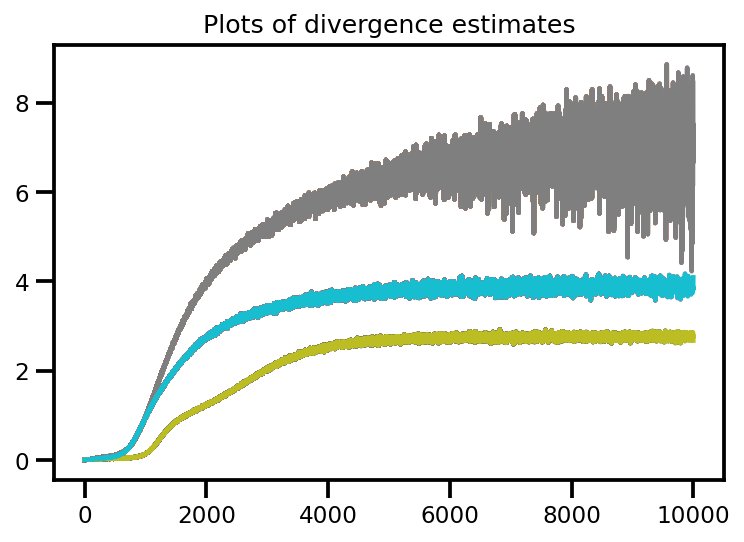

In [16]:
%%time

continue_train = True  # set to True to continue to train
num_big_steps = 100  # number of small steps
num_small_steps = 100  # number of big steps

with tqdm.trange(num_big_steps) as pbar:
    for k in pbar:
        for j in range(num_small_steps):
            pbar.set_description(f"# Small Steps: {j}")
            dXY_list = np.append(dXY_list, np.zeros((trials, 1)), axis=1)
            dX_list = np.append(dX_list, np.zeros((trials, 1)), axis=1)
            dY_list = np.append(dY_list, np.zeros((trials, 1)), axis=1)
            for i in range(trials):
                minee_list[i].step()
                dXY_list[i, -1], dX_list[i, -1], dY_list[i, -1] = minee_list[
                    i
                ].forward()
        # To show intermediate works
        for i in range(trials):
            plt.plot(dXY_list[i, :], label="dXY")
            plt.plot(dX_list[i, :], label="dX")
            plt.plot(dY_list[i, :], label="dY")
            plt.title("Plots of divergence estimates")
        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output()

### MINE-NEE

In [17]:
from pysim.information.mine import MINEE_MINE
import tqdm

ref_batch_factor = 10

minee_nee_list = []
for i_trial in range(trials):
    # generate data

    res_dict = generate_gaussian_mi_data(
        n_samples=n_samples, n_features=n_features, seed=i_trial,
    )

    # create torch tensors
    # create models
    X = torch.Tensor(res_dict.X)
    Y = torch.Tensor(res_dict.Y)

    # create list
    minee_nee_list.append(
        MINEE_MINE(
            X,
            Y,
            batch_size=batch_size,
            lr=lr,
            ref_batch_factor=ref_batch_factor,
            ma_rate=ma_rate,
        )
    )

# initialize differences
dXY_list = np.zeros((trials, 0))
dX_list = np.zeros((trials, 0))
dY_list = np.zeros((trials, 0))
mine_dXY_list = np.zeros((trials, 0))
mi_list = np.zeros((trials, 0))

CPU times: user 1h 9min 19s, sys: 2h 28min 37s, total: 3h 37min 56s
Wall time: 8min 49s


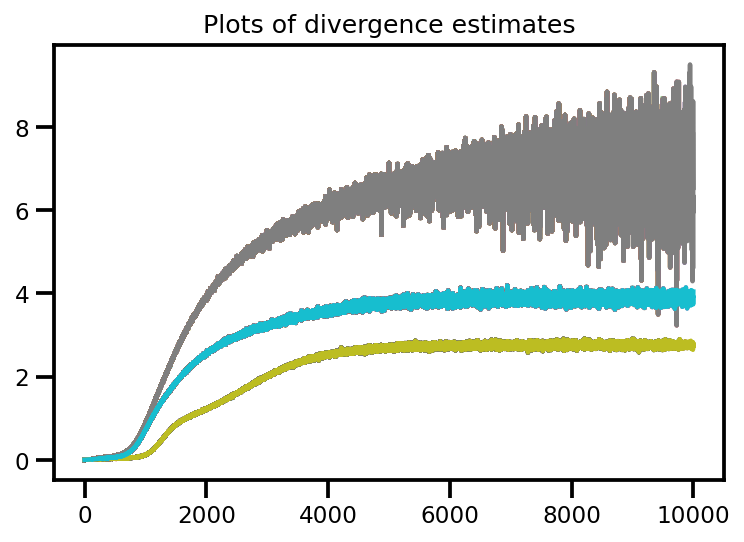

In [18]:
%%time

num_big_steps = 100  # number of small steps
num_small_steps = 100  # number of big steps


with tqdm.trange(num_big_steps) as pbar:
    for k in pbar:
        for j in range(num_small_steps):
            pbar.set_description(f"# Small Steps: {j}")
            dXY_list = np.append(dXY_list, np.zeros((trials, 1)), axis=1)
            dX_list = np.append(dX_list, np.zeros((trials, 1)), axis=1)
            dY_list = np.append(dY_list, np.zeros((trials, 1)), axis=1)
            mi_list = np.append(mi_list, np.zeros((trials, 1)), axis=1)
            for i in range(trials):
                minee_nee_list[i].step_minee()
                dXY_list[i, -1], dX_list[i, -1], dY_list[i, -1] = minee_nee_list[
                    i
                ].forward_minee()
                mi_list[i, -1] = (
                    dXY_list[i, -1] - dX_list[i, -1] - dY_list[i, -1]
                ).copy()
        # To show intermediate works
        for i in range(trials):
            plt.plot(dXY_list[i, :], label="dXY")
            plt.plot(dX_list[i, :], label="dX")
            plt.plot(dY_list[i, :], label="dY")
            plt.title("Plots of divergence estimates")
        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output()